# Script that perform modelling using different models

### Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict

### Uploading the matrix

In [2]:
matrix_TFIDF = pd.read_csv('TFIDF.csv')

In [21]:
matrix_TFIDF['Sentiment_Encoded'] = LabelEncoder().fit_transform(matrix_TFIDF['Sentiment'])

In [22]:
matrix_TFIDF['Sentiment_Encoded'].value_counts() # 2 - positive 1 - neutral 0 - negative

Sentiment_Encoded
2    70
1    24
0     6
Name: count, dtype: int64

### Splitting into train and test

In [26]:
X = matrix_TFIDF.iloc[:,0:-2]
Y = matrix_TFIDF.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
print(Y.value_counts())

Sentiment_Encoded
2    70
1    24
0     6
Name: count, dtype: int64


## Models

### Näive Bayes

In [29]:
# Naive Bayes
nb = GaussianNB()
                                                    
nb.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_nb = accuracy_score(Y_test, y_pred)
recall_nb = recall_score(Y_test, y_pred, average='micro')
f1_score_nb = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", accuracy_nb)
print("Recall:", recall_nb)
print("F1 Score:", f1_score_nb)

Accuracy: 0.75
Recall: 0.75
F1 Score: 0.75


As you can see the näive bayes classifiers performs pretty bad, probably due to the semplicistics assumptions under that model.

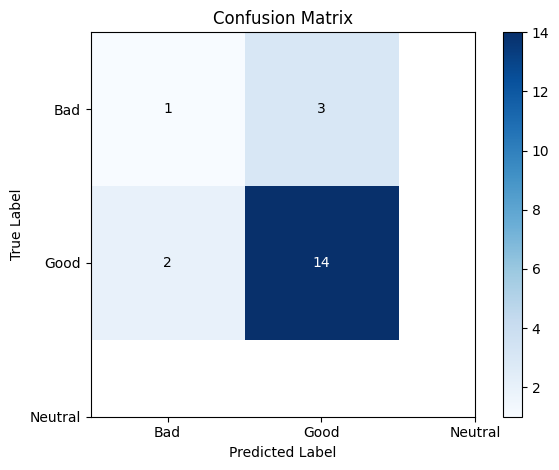

In [30]:
cm = confusion_matrix(Y_test, y_pred)

# Plot confusion matrix using 'cm' module from matplotlib
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=Blues)
ax.set_title("Confusion Matrix")
plt.colorbar(im)

# Add labels to matrix cells
classes = ['Bad', 'Good', 'Neutral']
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Add numerical values inside the matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()
plt.show()

To show that I computed the confusion matrix for that model. The most missclassified class is the bad one probably due to a train set that is too trained with good review (since there are many of them)

### Multinomial Bayes

In [31]:
fb = MultinomialNB()

fb.fit(X_train, Y_train)

# Step 5: Make predictions on the test set
y_pred = fb.predict(X_test)

# Step 6: Evaluate the performance of the classifier
accuracy_fb = accuracy_score(Y_test, y_pred)
recall_fb = recall_score(Y_test, y_pred, average='micro')
f1_score_fb = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", accuracy_fb)
print("Recall:", recall_fb)
print("F1 Score:", f1_score_fb)

Accuracy: 0.85
Recall: 0.85
F1 Score: 0.85


I thought could be interesting to compare the Näive Bayes with the Multinomial Bayes since the second works quite well with occurences of words within a text. Even though I don't have a dataset with occurences but with weights we can clearly see that the performance increased.

### Decision Tree

In [32]:
# Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, splitter='best')

# Train the classifier
dt.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_dt = accuracy_score(Y_test, y_pred)
recall_dt = recall_score(Y_test, y_pred, average='micro')
f1_score_dt = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", accuracy_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_score_dt)

Accuracy: 0.85
Recall: 0.85
F1 Score: 0.85


Decision Tree is one of the best models. I used as criterion entropy and for splitter best since, personally, they were the best options

### Random Forest

Implementing a Random Forest I thought It could be useful to check how many trees are the best choice to construct the Forest. In the code above I created a list of tuples containing "RandomForest Classifiers" string and as second element a tuple with the number of trees used and the OOB rate. Setting the attribute oob_score=True I can track every time the OOB score that is the probability of predicting the Out Of Bag samples correctly. The last part of the code plot a line chart where on the x axes there is the number of trees (from 50 to 500 with a step of 10) and the y axes the OOB rate.

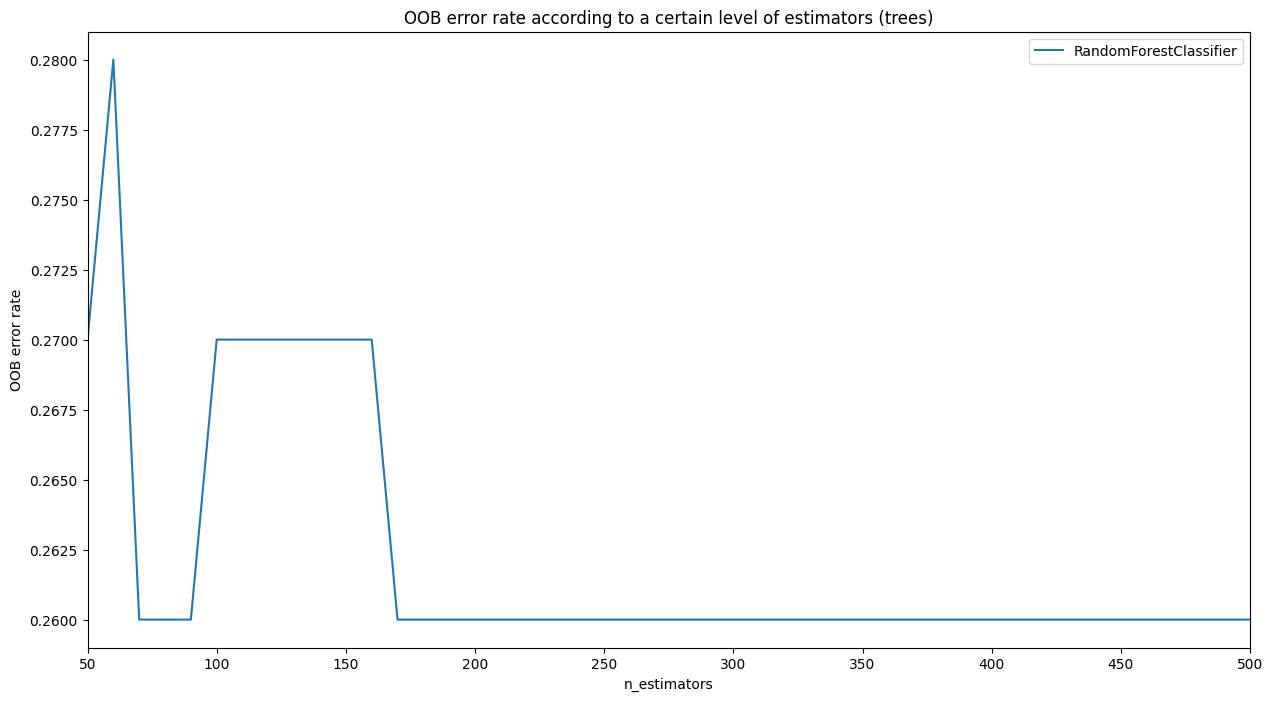

In [34]:
ensemble_rf = [
    ("RandomForestClassifier", RandomForestClassifier(warm_start=True, oob_score=True, random_state=42))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_rf)


min_estimators = 50
max_estimators = 500

for label, rf in ensemble_rf:
    for i in range(min_estimators, max_estimators + 1, 10):
        rf.set_params(n_estimators=i, random_state = 42)
        rf.fit(X, Y)
        oob_error = 1 - rf.oob_score_
        error_rate[label].append((i, oob_error))


for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err) # unzip the tuple with number of trees and OOB error
    plt.figure(figsize=(15,8))
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('OOB error rate according to a certain level of estimators (trees)')
plt.legend(loc="upper right")
plt.show()

After done that I applied some hyperparameter tuning in order to visualize which are the best parameter to obtain the highest accuracy, given the fact that the Random Forest has many parameter to set:

In [35]:
params = {'n_estimators' : [60, 90, 120],
          'criterion' : ['gini', 'entropy'],
          'max_depth' : [None, 4, 10, 15],
          'max_features' : ['sqrt', 'log2', None],
          'bootstrap' : [True, False]}

hyperparameter_tuning = GridSearchCV(RandomForestClassifier(), params, verbose=1, cv=3, n_jobs=-1)

hyp_res = hyperparameter_tuning.fit(X_train, Y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [36]:
hyp_res.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 120}

In [37]:
# Random Forest
rf = RandomForestClassifier(n_estimators=120, criterion='gini', random_state=42, bootstrap=False, max_depth=None, max_features='log2')

# Train the classifier
rf.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_rf = accuracy_score(Y_test, y_pred)
recall_rf = recall_score(Y_test, y_pred, average='micro')
f1_score_rf = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", accuracy_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_score_rf)

Accuracy: 0.9
Recall: 0.9
F1 Score: 0.9


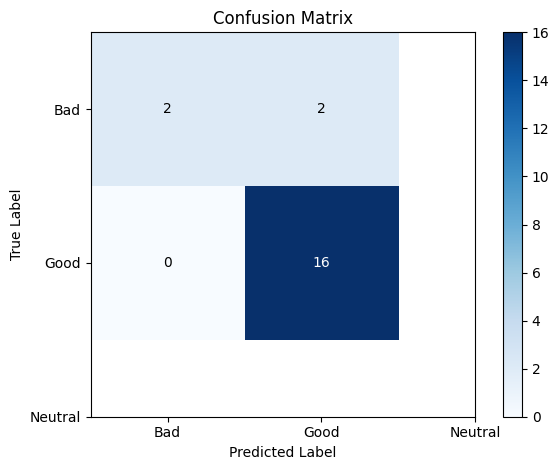

In [38]:
cm = confusion_matrix(Y_test, y_pred)

# Plot confusion matrix using 'cm' module from matplotlib
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=Blues)
ax.set_title("Confusion Matrix")
plt.colorbar(im)

# Add labels to matrix cells
classes = ['Bad', 'Good', 'Neutral']
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Add numerical values inside the matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Also there I computed the confusion matrix. Since the Random Forest is the best model (spoiler) we can clearly see that most of the review have been classified correctly

### Logistic Regression

In [39]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Fit the model to the training data
logreg.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test)

# Calculate the accuracy of the model
accuracy_lr = accuracy_score(Y_test, y_pred)
recall_lr = recall_score(Y_test, y_pred, average='micro')
f1_score_lr = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", accuracy_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_score_lr)

Accuracy: 0.85
Recall: 0.85
F1 Score: 0.85


The final model I implmented is the logistic regression. This happens to be one of the worst maybe due to the fact that it is a linear model and the dataset in input could not be the best choice for this model.

### Dataframe with results

In [40]:
results = pd.DataFrame({'Model Name' : ['Naive Bayes', 'Full Bayes' ,'Decision Tree', 'Random Forest', 'Logistic Regression'], 
                                'Accuracy' : [accuracy_nb, accuracy_fb , accuracy_dt, accuracy_rf, accuracy_lr],
                                'Recall' : [recall_nb, recall_fb, recall_dt, recall_rf, recall_lr],
                                'F1 Score' : [f1_score_nb, f1_score_fb, f1_score_dt, f1_score_rf, f1_score_lr]})

In [41]:
results

,Model Name,Accuracy,Recall,F1 Score
0,Naive Bayes,0.75,0.75,0.75
1,Full Bayes,0.85,0.85,0.85
2,Decision Tree,0.85,0.85,0.85
3,Random Forest,0.90,0.90,0.90
4,Logistic Regression,0.85,0.85,0.85
